In [14]:
%matplotlib notebook
import importlib
import numpy
import sqlite3
import matplotlib.pyplot as plt

try:
    importlib.reload(wi_parser)
except NameError:
    import wi_parser

In [ ]:
# test loading a particular entry from the CIR file
rxID = 25
cirData25 = wi_parser.loadEntryCIR("data/simple_walk/lora multifreq rosslyn.cir.t002_05.r009.p2m", rxID)
print("{} paths found for rxID {}".format(len(cirData25), rxID))

# test loading all entries from CIR file
cirData = wi_parser.loadAllCIR("data/simple_walk/lora multifreq rosslyn.cir.t002_05.r009.p2m", 9)
# get rid of entries without CIR data
cirData = {rxid:cir for rxid,cir in cirData.items() if len(cir) > 0}
print("{} RX entries found".format(len(cirData)))

In [2]:
# project and data parameters
project="lora multifreq rosslyn"
studyarea="simple walk"
projectdir="data"
txset = 3
txID = 2
rxset = 9

# get transmitter and reciever positions from SQL file
sqlfile = wi_parser.sqlfilename(project=project,
                         studyarea=studyarea,
                         projectdir=projectdir)
print("using SQL file:", sqlfile)

txpos = wi_parser.parsePos(sqlfile, devType="txset", setid=txset)
print("# of TX entries:", len(txpos))
rxpos = wi_parser.parsePos(sqlfile, devType="rxset", setid=rxset)
print("# of RX entries:", len(rxpos))

# find line of sight distances between sets of transmitters and receivers
distances = wi_parser.computeDistancesLOS(txpos, rxpos)
print("# of distance entries:", len(distances))

# find ideal time of arrival between tx and rx devices
toa = wi_parser.computeToaLOS(distances)
print("# of ToA entries:", len(toa))

using SQL file: data/simple walk/lora multifreq rosslyn.simple walk.sqlite
# of TX entries: 5
# of RX entries: 1849
# of distance entries: 9245
# of ToA entries: 9245


In [3]:
# parse CIR entries
cirfile = wi_parser.outputfilename(project=project,
                                   studyarea=studyarea,
                                   output="cir",
                                   txset=txset,
                                   txn=txID, 
                                   rxset=rxset, 
                                   projectdir=projectdir)
print("using output file:", cirfile)
cir = wi_parser.loadAllCIR(cirfile, rxset, txset, txID)
# remove any entries which have zero paths
cir = {linkid:cirentry for linkid,cirentry in cir.items() if len(cirentry) > 0}
print("# of (non empty) CIR entries:", len(cir))

using output file: data/simple walk/lora multifreq rosslyn.cir.t002_03.r009.p2m
# of (non empty) CIR entries: 701


In [4]:
# parse delay spread and location

        
project="lora multifreq rosslyn"
studyarea="simple walk"
projectdir="data"
txset = 3
txid = 2
rxset = 9

dsfile = wi_parser.outputfilename(project=project,
                                   studyarea=studyarea,
                                   output="spread",
                                   txset=txset,
                                   txn=txID, 
                                   rxset=rxset, 
                                   projectdir=projectdir)
print("dsfile:", dsfile)

ds, rxpos2, distances2 = wi_parser.loadDelaySpread(dsfile, rxset, txset, txid)

dsfile: data/simple walk/lora multifreq rosslyn.spread.t002_03.r009.p2m


In [5]:
# compare positions of some of the elements in the SQL file vs delay spread file
# this is to check if the position from the SQL file are interpreted correctly
i = 0
for rxid, pos in rxpos2.items():
    print(rxid)
    print("ds pos:", pos)
    print("sql pos:", rxpos[rxid])
    print()
    i = i+1
    if i > 5:
        break
        
# compare distances in the delay spread file vs distances from the positions
# this is to check if the distances in the delay spread file represent the distances between the tx and rx devices
i = 0
for entryid, dist in distances2.items():
    print(entryid)
    print("SQL distances:", distances[entryid])
    print("ds distances", dist)
    print()
    i = i+1
    if i > 5:
        break

(9, 1)
ds pos: [397.039 334.709  53.034]
sql pos: [397.03912354 334.70932007  53.03404433]

(9, 2)
ds pos: [407.039  334.709   52.8955]
sql pos: [407.03912354 334.70932007  52.89552976]

(9, 3)
ds pos: [417.039 334.709  52.757]
sql pos: [417.03912354 334.70932007  52.75701518]

(9, 4)
ds pos: [427.039  334.709   52.5659]
sql pos: [427.03912354 334.70932007  52.56589586]

(9, 5)
ds pos: [437.039  334.709   52.4896]
sql pos: [437.03912354 334.70932007  52.48960595]

(9, 6)
ds pos: [447.039  334.709   52.4896]
sql pos: [447.03912354 334.70932007  52.48960595]

((3, 2), (9, 1))
SQL distances: 239.9209725428763
ds distances 239.921

((3, 2), (9, 2))
SQL distances: 232.69204908343855
ds distances 232.692

((3, 2), (9, 3))
SQL distances: 225.6748650602343
ds distances 225.675

((3, 2), (9, 4))
SQL distances: 218.897650839966
ds distances 218.898

((3, 2), (9, 5))
SQL distances: 212.35757130463082
ds distances 212.358

((3, 2), (9, 6))
SQL distances: 206.08321369382247
ds distances 206.083



(0.0001, (0.00034+4.1e-05j))
(0.00012, (1.2e-05-1.2e-05j))
(0.000135, (0.00032+7.8e-05j))
(0.00017, (1e-07-2.3e-06j))


<IPython.core.display.Javascript object>


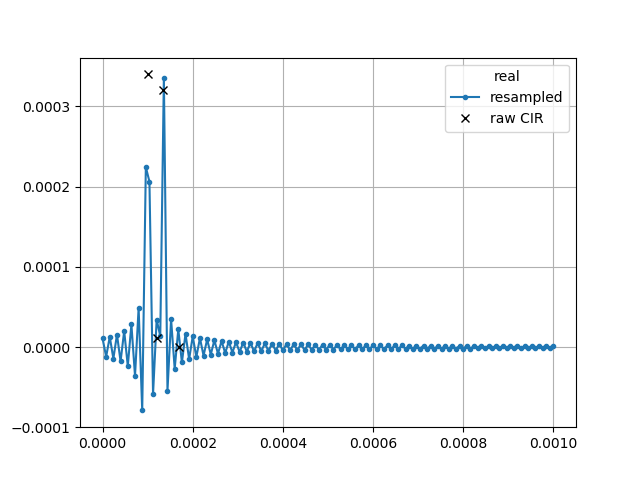

<IPython.core.display.Javascript object>


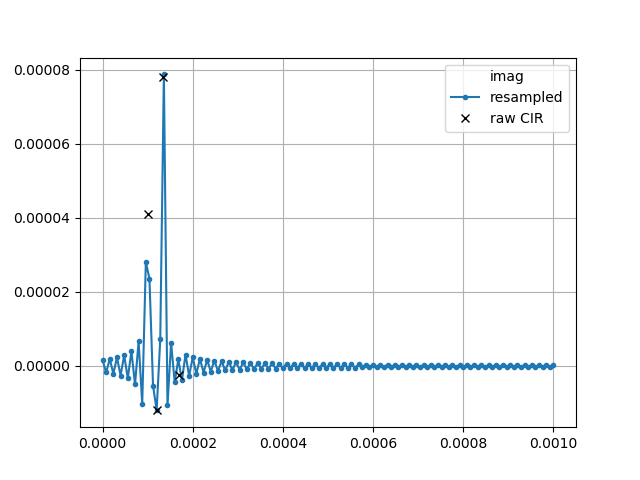

In [30]:
# given a list of times and complex CIRs, find what a narrowband reinterpretation would look like
cirList = [(1e-4, 3.4e-4+4.1e-5j),
           (1.2e-4, 1.2e-5-1.2e-5j),
           (1.35e-4, 3.2e-4+7.8e-5j),
           (1.7e-4, 1e-7-2.3e-6j)]

print(*cirList, sep='\n')

def tRespCIR(cirList, t, Ts):
    r = np.complex64(0.0)
    for cirEntry in cirList:
        toa, cir = cirEntry
        dt = t - toa
        r = r + cir*np.sinc(dt/Ts)
    return r

def resampleCIR(cirList, Ts, tEnd, tOff=0):
    tsamples = np.arange(tOff, tEnd, Ts)
    cirArray = np.zeros(tsamples.size, dtype=np.complex64)
    for i,t in enumerate(tsamples):
        cirArray[i] = tRespCIR(cirList, t, Ts)
    return cirArray, tsamples

def cirListToArray(cirList):
    tArr = np.array(list(map(lambda x: x[0], cirList)))
    cirArr = np.array(list(map(lambda x: x[1], cirList)))
    return cirArr, tArr
    

bw = 125e3
ts = 1/bw

y, t = resampleCIR(cirList, ts, 1e-3)
cirArr, tArr = cirListToArray(cirList)

plt.figure()
plt.plot(t, y.real, 'C0.-', label="resampled")
plt.plot(tArr, cirArr.real, 'kx', label="raw CIR")
plt.legend(title="real")
plt.grid()

plt.figure()
plt.plot(t, y.imag, 'C0.-', label="resampled")
plt.plot(tArr, cirArr.imag, 'kx', label="raw CIR")
plt.legend(title="imag")
plt.grid()


plt.show()